[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/CV/blob/main/low_res2high_res/gans.ipynb)

In [30]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import kagglehub
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn as nn
from torch import optim
from torchvision.utils import save_image
from torchvision.models import vgg19

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True

# **Dataset**

In [3]:
path = kagglehub.dataset_download("adityachandrasekhar/image-super-resolution")
print("Path to dataset files:", path)

100%|██████████| 301M/301M [00:04<00:00, 76.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityachandrasekhar/image-super-resolution/versions/2


In [4]:
class MyImageFolder(Dataset):
    def __init__(self):
        super(MyImageFolder, self).__init__()
        self.base = "/root/.cache/kagglehub/datasets/adityachandrasekhar/image-super-resolution/versions/2/dataset/train"
        self.high_images = os.listdir(self.base + '/high_res')
        self.low_images = os.listdir(self.base + '/low_res')

    def __len__(self):
        return len(self.high_images)

    def __getitem__(self, index):

        # finding image index
        high_img = self.high_images[index % len(self.high_images)]
        low_img = self.low_images[index % len(self.low_images)]

        # finding image path
        high_path = os.path.join(self.base + "/high_res", high_img)
        low_path = os.path.join(self.base + "/low_res", low_img)

        # opening image and storing in array
        high_img = np.array(Image.open(high_path).convert("RGB"))
        low_img = np.array(Image.open(low_path).convert("RGB"))

        # performing transformations on the images zebra and horses
        transforms = A.Compose([A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ToTensorV2()])
        high_res = transforms(image=high_img)["image"]
        low_res = transforms(image=low_img)["image"]

        return low_res, high_res

In [5]:
dataset = MyImageFolder()
loader = DataLoader( dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# **Modelling**

In [6]:
class Generator(nn.Module):
    def __init__(self, img_channels=3, num_features=64, num_residuals=9):
        super().__init__()
        self.model = nn.Sequential(
                                        nn.Conv2d(3, 64, 7, 1, 3, padding_mode="reflect"), nn.InstanceNorm2d(64), nn.ReLU(inplace=True),
                                        nn.Conv2d(64, 128, 3, 2, 1, padding_mode="reflect"), nn.InstanceNorm2d(128), nn.ReLU(inplace=True),
                                        nn.Conv2d(128, 256, 3, 2, 1, padding_mode="reflect"), nn.InstanceNorm2d(256), nn.ReLU(inplace=True),
                                        nn.ConvTranspose2d(256, 128, 3, 2, 1, 1), nn.InstanceNorm2d(128),nn.ReLU(inplace=True),
                                        nn.ConvTranspose2d(128, 64, 3, 2, 1, 1), nn.InstanceNorm2d(64),nn.ReLU(inplace=True),
                                        nn.Conv2d(64, 3, 7, 1, 3, padding_mode="reflect")
                        )

    def forward(self, x):
        return torch.tanh(self.model(x))

In [8]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
                                    nn.Conv2d(3, 64, 4, 2, 1, padding_mode="reflect"), nn.LeakyReLU(0.2, inplace=True),
                                    nn.Conv2d(64, 128, 4, 2, 1, bias = True, padding_mode="reflect"), nn.InstanceNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
                                    nn.Conv2d(128, 256, 4, 2, 1, bias = True, padding_mode="reflect"), nn.InstanceNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
                                    nn.Conv2d(256, 512, 4, 1, 1, bias = True, padding_mode="reflect"), nn.InstanceNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
                                    nn.Conv2d(512, 1, 4, 1, 1, padding_mode="reflect")
                                  )

    def forward(self, x):
        return torch.sigmoid(self.model(x))

# **Training**

In [9]:
# instantiate the model
gen = Generator().to(DEVICE)
disc = Discriminator().to(DEVICE)

In [10]:
# Optimizers
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [11]:
# losses
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval().to(DEVICE)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)


mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = VGGLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 138MB/s]


In [12]:
for epoch in range(50):
    loop = tqdm(loader, leave=True)

    for idx, (low_res, high_res) in enumerate(loop):

        high_res = high_res.to(DEVICE)
        low_res = low_res.to(DEVICE)



        ''' Training Discriminator first keeping Generator Constant '''
        fake = gen(low_res)
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        '''Training Generator Next Keeping Discriminator Constant'''
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()


100%|██████████| 43/43 [00:45<00:00,  1.06s/it]


# **Inference**

array([[[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [233, 248, 172],
        [232, 248, 176],
        [232, 248, 176]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [233, 248, 172],
        [232, 248, 176],
        [232, 248, 176]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [234, 248, 174],
        [234, 249, 179],
        [234, 249, 179]],

       ...,

       [[131, 124, 123],
        [131, 124, 123],
        [129, 123, 122],
        ...,
        [190, 217, 242],
        [186, 214, 240],
        [186, 214, 240]],

       [[131, 124, 122],
        [131, 124, 122],
        [129, 123, 121],
        ...,
        [191, 218, 242],
        [188, 216, 241],
        [188, 216, 241]],

       [[131, 124, 122],
        [131, 124, 122],
        [129, 123, 121],
        ...,
        [191, 218, 242],
        [188, 216, 241],
        [188, 216, 241]]], dtype=uint8)
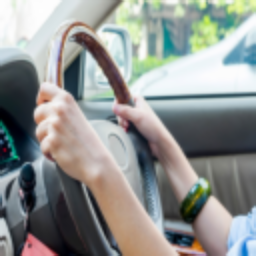

In [28]:
gen.eval()
image = np.array(Image.open("/root/.cache/kagglehub/datasets/adityachandrasekhar/image-super-resolution/versions/2/dataset/train/low_res/169.png").convert("RGB"))
image

In [29]:
# generating upscaled image
with torch.no_grad():
    test_transform = A.Compose([A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),ToTensorV2()])
    transformed_img = test_transform(image = image)["image"]
    upscaled_img = gen(transformed_img.unsqueeze(0).to(DEVICE))

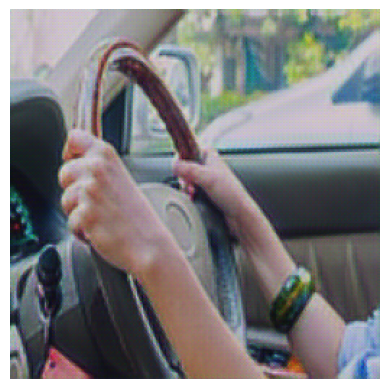

In [31]:
# displaying the upscaled image
upscaled_image_array = upscaled_img.squeeze(0).cpu().numpy()
upscaled_image_array = np.transpose(upscaled_image_array, (1, 2, 0))

# denormalizing
upscaled_image_array = 0.5*upscaled_image_array + 0.5

plt.imshow(upscaled_image_array)
plt.axis('off')
plt.show()